In [1]:
import torch
import pandas as pd
from torch.optim import AdamW
from transformers import T5ForConditionalGeneration
import torch.nn as nn
from src.load_dataloader import initial_dataloader_vector_slicing
from tqdm import tqdm
from src.evaluation import initial_LSTM
from src.load_config import load_config
import torch.nn.functional as F

batch_size = 32
max_length = 64
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
torch.autograd.set_detect_anomaly(True)

_, tokenizer, device = load_config(max_length)
# import data
df = pd.read_csv('data_preprocess/datasets_combine.csv')
train_df, val_df,test_df, train_dataset,val_dataset, test_dataset,train_loader, val_loader, test_loader = initial_dataloader_vector_slicing(df, tokenizer, max_length,batch_size)
LSTM_model = initial_LSTM(tokenizer, device)

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [2]:
def call_tokenizer(text,max_length,device):
    output = tokenizer(text, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt').to(device)
    return output['input_ids'].to(device), output['attention_mask'].to(device)

def reparameterize(mean, log_variance):
    """Reparameterization trick to sample from the Normal distribution.
    
    Args:
    mean (torch.Tensor): Mean of the desired Normal distribution.
    log_variance (torch.Tensor): Log variance of the desired Normal distribution.

    Returns:
    A sample from the specified Normal distribution.
    """
    std = torch.exp(0.5 * log_variance)  # Get standard deviation from log variance
    eps = torch.randn_like(std)  # Sample a random tensor with shape like std from the standard Normal distribution
    return mean + eps * std  # Scale and shift eps

def classify_sentence(predicted_token_ids, lstm_model):
    # convert predicted_token_ids to text first
    texts1 = tokenizer.batch_decode(predicted_token_ids, skip_special_tokens=True)
    # convert back to token ids
    predicted_token_ids = tokenizer(texts1, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')['input_ids'].to(device)
    
    #predicted_token_ids = tokenizer(texts1, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')['input_ids'].to(device)

    # Initialize a tensor to store LSTM outputs
    lstm_outputs = torch.empty(size=(predicted_token_ids.shape[0], 2)).to(device)  # 2 for binary classification

    # Process each item in the batch
    for idx, token_ids in enumerate(predicted_token_ids):
        lstm_model.eval()
        with torch.no_grad():
            # Assuming lstm_model.predict returns a tensor of shape [1, 2] (probability for each class)
            lstm_output = lstm_model(token_ids.flatten())  # Modify this call according to your LSTM model's interface
            lstm_outputs[idx] = lstm_output

    return lstm_outputs

def kl_divergence(mean, log_var):
    return -0.5 * torch.sum(1 + log_var - mean**2 - log_var.exp())

def intra_sentence_similarity_loss(hidden_tensors):
    """
    Calculate a loss that encourages hidden vectors within each sentence to be similar.
    
    Args:
    hidden_tensors (torch.Tensor): A tensor of shape (batch_size, max_sentence_length, hidden_dim)
    
    Returns:
    torch.Tensor: Scalar tensor representing the loss.
    """
    batch_size, max_sentence_length, hidden_dim = hidden_tensors.size()

    # Initialize loss
    loss = 0.0

    # Compute pairwise cosine similarity within each sentence
    for i in range(batch_size):
        sentence_vectors = hidden_tensors[i]  # Shape: [max_sentence_length, hidden_dim]
        
        # Compute similarity matrix for the sentence
        similarity_matrix = F.cosine_similarity(sentence_vectors.unsqueeze(1), sentence_vectors.unsqueeze(0), dim=-1)

        # Mask to exclude self-comparisons and extract upper triangular part
        mask = torch.triu(torch.ones_like(similarity_matrix), diagonal=1).bool()
        similarity_values = similarity_matrix.masked_select(mask)

        # Accumulate loss (1 - similarity)
        loss = torch.mean(torch.abs(1 - similarity_values))

    # Normalize the loss by batch size
    loss = loss / batch_size

    return loss

def intra_sentence_diff_loss(hidden_tensors):
    """
    Calculate a loss that encourages sentence vectors to be different.
    
    Args:
    hidden_tensors (torch.Tensor): A tensor of shape (batch_size, max_sentence_length, hidden_dim)
    
    Returns:
    torch.Tensor: Scalar tensor representing the loss.
    """
    batch_size, max_sentence_length, hidden_dim = hidden_tensors.size()

    # Initialize loss
    loss = 0.0

    # Compute average vector for each sentence
    sentence_vectors = torch.mean(hidden_tensors, dim=1)  # Shape: [batch_size, hidden_dim]

    # Compute pairwise cosine similarity between sentences
    similarity_matrix = F.cosine_similarity(sentence_vectors.unsqueeze(1), sentence_vectors.unsqueeze(0), dim=-1)

    # Mask to exclude self-comparisons and extract upper triangular part
    mask = torch.triu(torch.ones_like(similarity_matrix), diagonal=1).bool()
    similarity_values = similarity_matrix.masked_select(mask)

    # Accumulate loss to maximize difference (minimize similarity) 
    loss = torch.mean(torch.abs(similarity_values))

    return loss

def similarity_loss(tensor1, tensor2):
    """
    Calculate a loss that penalizes the similarity between two tensors.
    
    Args:
    tensor1 (torch.Tensor): First tensor of shape (batch_size, seq_length, features).
    tensor2 (torch.Tensor): Second tensor of shape (batch_size, seq_length, features).

    Returns:
    torch.Tensor: Scalar tensor representing the similarity loss.
    """
    batch_size, seq_length, features = tensor1.size()

    # Reshape tensors to compute pairwise cosine similarity
    tensor1_flat = tensor1.view(batch_size * seq_length, features)
    tensor2_flat = tensor2.view(batch_size * seq_length, features)

    # Compute cosine similarity
    cosine_sim = F.cosine_similarity(tensor1_flat, tensor2_flat, dim=1)

    # Use cosine similarity directly as the loss
    loss = torch.mean(torch.abs(cosine_sim))

    return loss

In [3]:
class T5Encoder(nn.Module):
    def __init__(self, max_length):
        super(T5Encoder, self).__init__()
        # Load the pretrained T5-small model
        self.t5_encoder = T5ForConditionalGeneration.from_pretrained('t5-small',max_length = max_length)
        
    def forward(self, input_ids, attention_mask):
        # Pass the inputs through the T5-small model
        outputs = self.t5_encoder.encoder(input_ids=input_ids, attention_mask=attention_mask)
        
        return outputs
    
class T5Decoder(nn.Module):
    def __init__(self, max_length):
        super(T5Decoder, self).__init__()
        self.t5_decoder = T5ForConditionalGeneration.from_pretrained('t5-small',max_length = max_length)

    def forward(self, encoder_output, decoder_input_ids):
        # Pass the inputs through the T5-small model
        outputs = self.t5_decoder(decoder_input_ids = decoder_input_ids, encoder_outputs=encoder_output)
        
        return outputs.logits
    
class style_transform_model_encoder(nn.Module):
    def __init__(self, max_length):
        super(style_transform_model_encoder, self).__init__()
        self.content_encoder = T5Encoder(max_length)
        self.style_encoder = T5Encoder(max_length) 
        
    def forward(self, input_ids1 ,attention_mask1, input_ids2 ,attention_mask2):
        encoder_content_output1 = self.content_encoder(input_ids1,attention_mask1)
        encoder_style_output1 = self.style_encoder(input_ids1,attention_mask1)
        
        encoder_content_output2 = self.content_encoder(input_ids2,attention_mask2)
        encoder_style_output2 = self.style_encoder(input_ids2,attention_mask2)
        
        return encoder_content_output1, encoder_content_output2, encoder_style_output1, encoder_style_output2
    
class style_transform_model_decoder(nn.Module):
        def __init__(self, max_length):
            super(style_transform_model_decoder, self).__init__()
            self.decoder = T5Decoder(max_length)
            
        def forward(self, original_encoder_output1, original_encoder_output2, transfer_encoder_output1, transfer_encoder_output2, decoder_input_ids1, decoder_input_ids2):
            # reconstruct sentence
            sentence1_original = self.decoder(original_encoder_output1, decoder_input_ids1)
            sentence2_original = self.decoder(original_encoder_output2, decoder_input_ids2)
            
            sentence1_style2 = self.decoder(transfer_encoder_output1, decoder_input_ids1)
            sentence2_style1 = self.decoder(transfer_encoder_output2, decoder_input_ids2)
            
            return sentence1_original, sentence2_original, sentence1_style2, sentence2_style1


In [4]:
model_encoder = style_transform_model_encoder(max_length).to(device)
model_decoder = style_transform_model_decoder(max_length).to(device)
# show model structure
print(model_encoder)

style_transform_model_encoder(
  (content_encoder): T5Encoder(
    (t5_encoder): T5ForConditionalGeneration(
      (shared): Embedding(32128, 512)
      (encoder): T5Stack(
        (embed_tokens): Embedding(32128, 512)
        (block): ModuleList(
          (0): T5Block(
            (layer): ModuleList(
              (0): T5LayerSelfAttention(
                (SelfAttention): T5Attention(
                  (q): Linear(in_features=512, out_features=512, bias=False)
                  (k): Linear(in_features=512, out_features=512, bias=False)
                  (v): Linear(in_features=512, out_features=512, bias=False)
                  (o): Linear(in_features=512, out_features=512, bias=False)
                  (relative_attention_bias): Embedding(32, 8)
                )
                (layer_norm): T5LayerNorm()
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (1): T5LayerFF(
                (DenseReluDense): T5DenseActDense(
                  (wi)

In [5]:
combined_params = list(model_encoder.parameters()) + list(model_decoder.parameters())
optimizer = AdamW(combined_params, lr=5e-5)
#optimizer_classification = AdamW(model.style_encoder.parameters(), lr=5e-5)
# frozen decoder
#for param in model.decoder.parameters():
   #param.requires_grad = False

num_epochs = 5
loss_reconstruct = nn.CrossEntropyLoss()
# loss_reconstruct_index = torch.ones([1], dtype=torch.float64, device=device)
loss_classification = nn.CrossEntropyLoss()
kl_weight = 0.0001
style_similarANDdiff_loss_weight = 10
style_loss_weight = 1
reconstruct_loss_weight = 1
sentence_similar_loss_weight = 10

reconstruct_loss_list = []
style_similar_loss_list = []
content_diff_loss_list = []
kl_loss_list = []
sentence_similar_loss_list = []
style_loss_list = []
total_loss_list = []

for epoch in tqdm(range(num_epochs)):
    model_encoder.train()
    model_decoder.train()
    
    for index,batch in enumerate(train_loader):
        input_ids1 = batch['input_ids1'].to(device)
        attention_mask1 = batch['attention_mask1'].to(device)
        labels1 = batch['sentence2_style'].to(device)
        
        input_ids2 = batch['input_ids2'].to(device)
        attention_mask2 = batch['attention_mask2'].to(device)
        labels2 = batch['sentence1_style'].to(device)

        encoder_content_output1, encoder_content_output2, encoder_style_output1, encoder_style_output2 = model_encoder(input_ids1 ,attention_mask1, input_ids2 ,attention_mask2)
        
        content_hidden_state1 = encoder_content_output1.last_hidden_state
        style_hidden_state1 = encoder_style_output1.last_hidden_state
        content_hidden_state2 = encoder_content_output2.last_hidden_state
        style_hidden_state2 = encoder_style_output2.last_hidden_state
        
        # calculate kl loss
        kl_loss1 = kl_divergence(content_hidden_state1, style_hidden_state1)
        kl_loss2 = kl_divergence(content_hidden_state2, style_hidden_state2)
        kl_loss = (kl_loss1 + kl_loss2) * kl_weight
        
        # latent vectors should be different
        sentence_similar_loss = similarity_loss(content_hidden_state1, content_hidden_state2) + similarity_loss(style_hidden_state1, style_hidden_state2) * sentence_similar_loss_weight
        
        # the vectors in style_hidden_state should be similar to each other
        style_similar_loss = (intra_sentence_similarity_loss(style_hidden_state1) + intra_sentence_similarity_loss(style_hidden_state2)) * style_similarANDdiff_loss_weight
        content_diff_loss = (intra_sentence_diff_loss(content_hidden_state1) + intra_sentence_diff_loss(content_hidden_state2)) * style_similarANDdiff_loss_weight
        
        # reconstruct the sentence
        sentence1_original_latent = reparameterize(content_hidden_state1, style_hidden_state1)
        sentence2_original_latent = reparameterize(content_hidden_state2, style_hidden_state2)
        original_encoder_output1 = encoder_content_output1
        original_encoder_output1.hidden_states = sentence1_original_latent
        original_encoder_output2 = encoder_content_output2
        original_encoder_output2.hidden_states = sentence2_original_latent
        
        # style transfer the sentence
        sentence1_style2_latent = reparameterize(content_hidden_state1, style_hidden_state2)
        sentence2_style1_latent = reparameterize(content_hidden_state2, style_hidden_state1)
        transfer_encoder_output1 = encoder_content_output1
        transfer_encoder_output1.hidden_states = sentence1_style2_latent
        transfer_encoder_output2 = encoder_content_output2
        transfer_encoder_output2.hidden_states = sentence2_style1_latent
        
        # call decoder
        decoder_input = tokenizer('', padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')['input_ids'].to(device)
        decoder_input = decoder_input.repeat(input_ids1.shape[0],1)
        sentence1_original, sentence2_original, sentence1_style2, sentence2_style1 = model_decoder(original_encoder_output1, original_encoder_output2, transfer_encoder_output1, transfer_encoder_output2, decoder_input, decoder_input)
    
        
        # reconstruct_loss
        sentence1_original_copy = sentence1_original.clone()
        sentence2_original_copy = sentence2_original.clone()
        
        loss1 = loss_reconstruct(sentence1_original_copy.view(-1, sentence1_original_copy.shape[-1]), input_ids1.view(-1))
        loss2 = loss_reconstruct(sentence2_original_copy.view(-1, sentence2_original_copy.shape[-1]), input_ids2.view(-1))
        
        reconstruct_loss = (loss1 + loss2) * reconstruct_loss_weight
         
        # classification loss
        sentence1_style2_copy = sentence1_style2.clone()
        sentence2_style1_copy = sentence2_style1.clone() 
        
        sentence1_style2_copy = torch.argmax(sentence1_style2_copy, dim=-1).to(device)
        sentence2_style1_copy = torch.argmax(sentence2_style1_copy, dim=-1).to(device)
        
        Predicted_labels1 = classify_sentence(sentence1_style2_copy, LSTM_model)
        Predicted_labels2 = classify_sentence(sentence2_style1_copy, LSTM_model)
        
        style_loss1 = loss_classification(Predicted_labels1, labels1)
        style_loss2 = loss_classification(Predicted_labels2, labels2)
        
        style_loss = (style_loss1 + style_loss2) * style_loss_weight
        
        total_loss = reconstruct_loss + style_similar_loss + content_diff_loss + style_loss + kl_loss + sentence_similar_loss
        
        # record loss
        reconstruct_loss_list.append(reconstruct_loss.item())
        style_similar_loss_list.append(style_similar_loss.item())
        content_diff_loss_list.append(content_diff_loss.item())
        kl_loss_list.append(kl_loss.item())
        style_loss_list.append(style_loss.item())
        total_loss_list.append(total_loss.item())
        sentence_similar_loss_list.append(sentence_similar_loss.item())
        
        # train the model
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()
        if index % 50 == 0:
            print(f"Epoch: {epoch}, Batch: {index}, reconstruct_loss: {reconstruct_loss.item()}, style_similar_loss: {style_similar_loss.item()},content_diff_loss: {content_diff_loss.item()}, style_loss: {style_loss.item()}, kl_loss: {kl_loss.item()}, sentence_similar_loss: {sentence_similar_loss.item()}")
            print(f"Epoch: {epoch}, Batch: {index}, total_loss_loss: {total_loss.item()}")
            # print a reconstructed sentence
            sentence1_original_copy = torch.argmax(sentence1_original_copy, dim=-1).to(device)
            sentence1_original_sentence = tokenizer.decode(sentence1_original_copy[0], skip_special_tokens=True)
            sentence1_style2 = tokenizer.decode(sentence1_style2_copy[0], skip_special_tokens=True)
            print(sentence1_original_sentence)
            print(sentence1_style2)
            print("------------------")

  0%|          | 0/5 [00:00<?, ?it/s]c:\Users\Ene\Desktop\CS505_github\Natural-Language_Project\src\load_dataloader.py:179: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids1': torch.tensor(item['input_ids1'], dtype=torch.long).squeeze(0),
c:\Users\Ene\Desktop\CS505_github\Natural-Language_Project\src\load_dataloader.py:180: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  'input_ids2': torch.tensor(item['input_ids2'], dtype=torch.long).squeeze(0),
c:\Users\Ene\Desktop\CS505_github\Natural-Language_Project\src\load_dataloader.py:181: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(Tru

Epoch: 0, Batch: 0, reconstruct_loss: 16.64492416381836, style_similar_loss: 0.4511794149875641, style_diff_loss: 15.223663330078125, style_loss: 3.1520626544952393, kl_loss: 5.990291118621826, sentence_similar_loss: 3.1621711254119873
Epoch: 0, Batch: 0, total_loss_loss: 44.624290466308594
)

------------------


In [ ]:
# save pth file
torch.save(model_encoder.state_dict(), 'T5_model_2encoder/model_encoder.pth')
torch.save(model_decoder.state_dict(), 'T5_model_2encoder/model_decoder.pth')

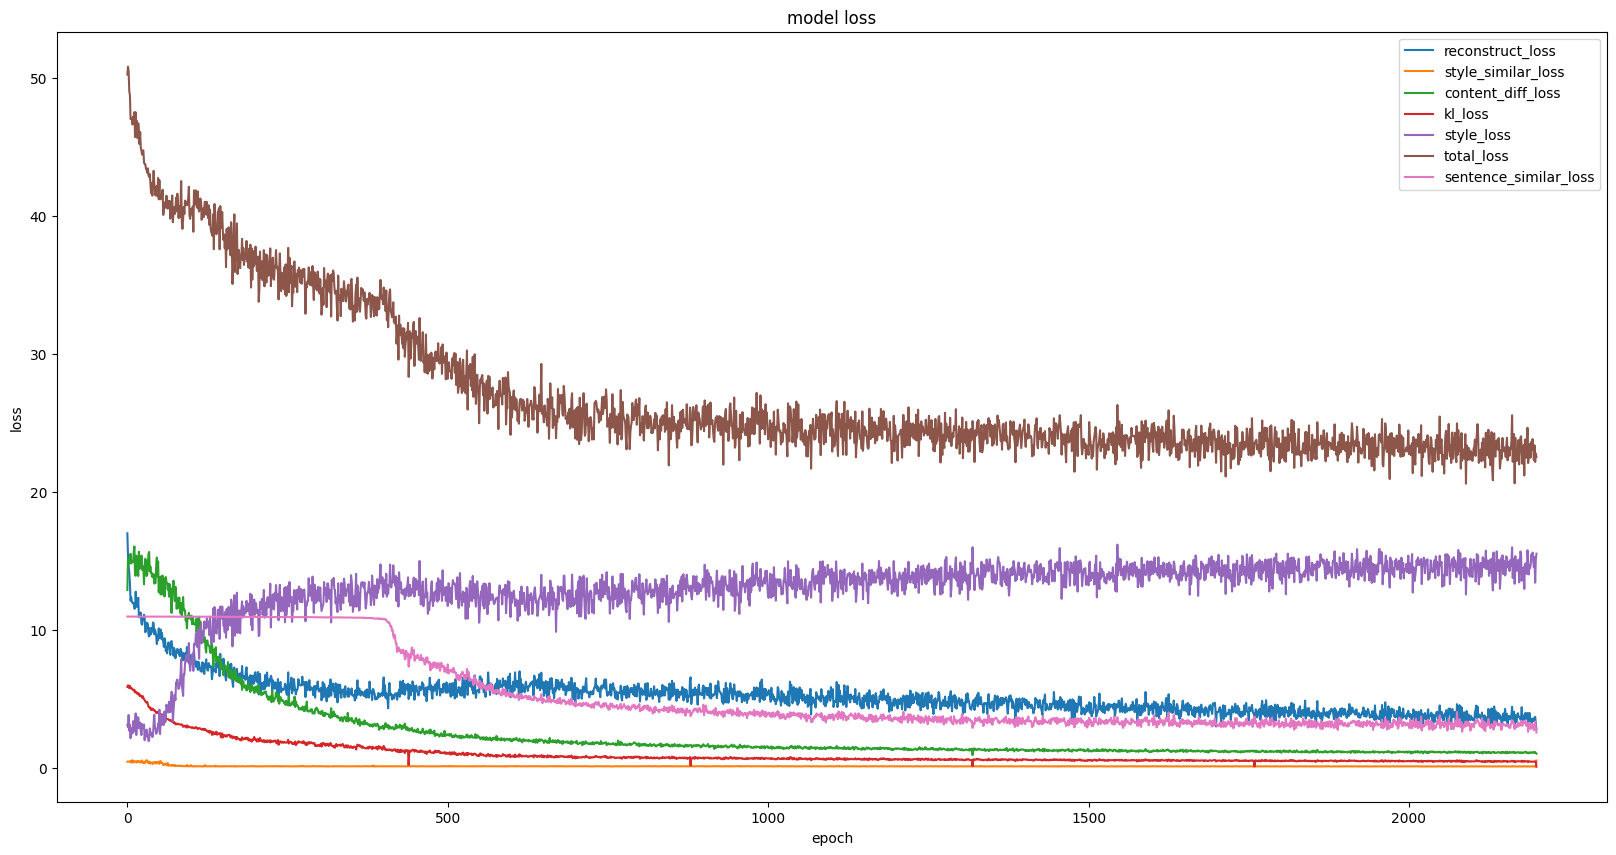

In [ ]:
# plot all loss
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
plt.plot(reconstruct_loss_list)
plt.plot(style_similar_loss_list)
plt.plot(content_diff_loss_list)
plt.plot(kl_loss_list)
plt.plot(style_loss_list)
plt.plot(total_loss_list)
plt.plot(sentence_similar_loss_list)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['reconstruct_loss', 'style_similar_loss', 'content_diff_loss', 'kl_loss','style_loss', 'total_loss',"sentence_similar_loss"], loc='upper right')
plt.show()
